In [1]:
import sys
sys.path.append('/vol/tensusers4/nhollain/thesis2023-2024/s_clip_scripts')
# Local imports
from params import parse_args
from data_loader import get_data
from tuning_tools import prep_str_args

from open_clip import create_model_and_transforms, get_tokenizer, create_loss

from tqdm import tqdm
import numpy as np
import os
from PIL import Image
import cv2

args = parse_args([])
model, preprocess_train, preprocess_val = create_model_and_transforms(
        args.model, args.pretrained, precision=args.precision, device=args.device, output_dict=True,
        aug_cfg = args.aug_cfg, )
datasets = ["WHU-RS19", "RSSCN7", "AID", "RESISC45"]

[nltk_data] Downloading package punkt to /home/nhollain/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nhollain/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Generalized Gaussian Distribution (GGD)

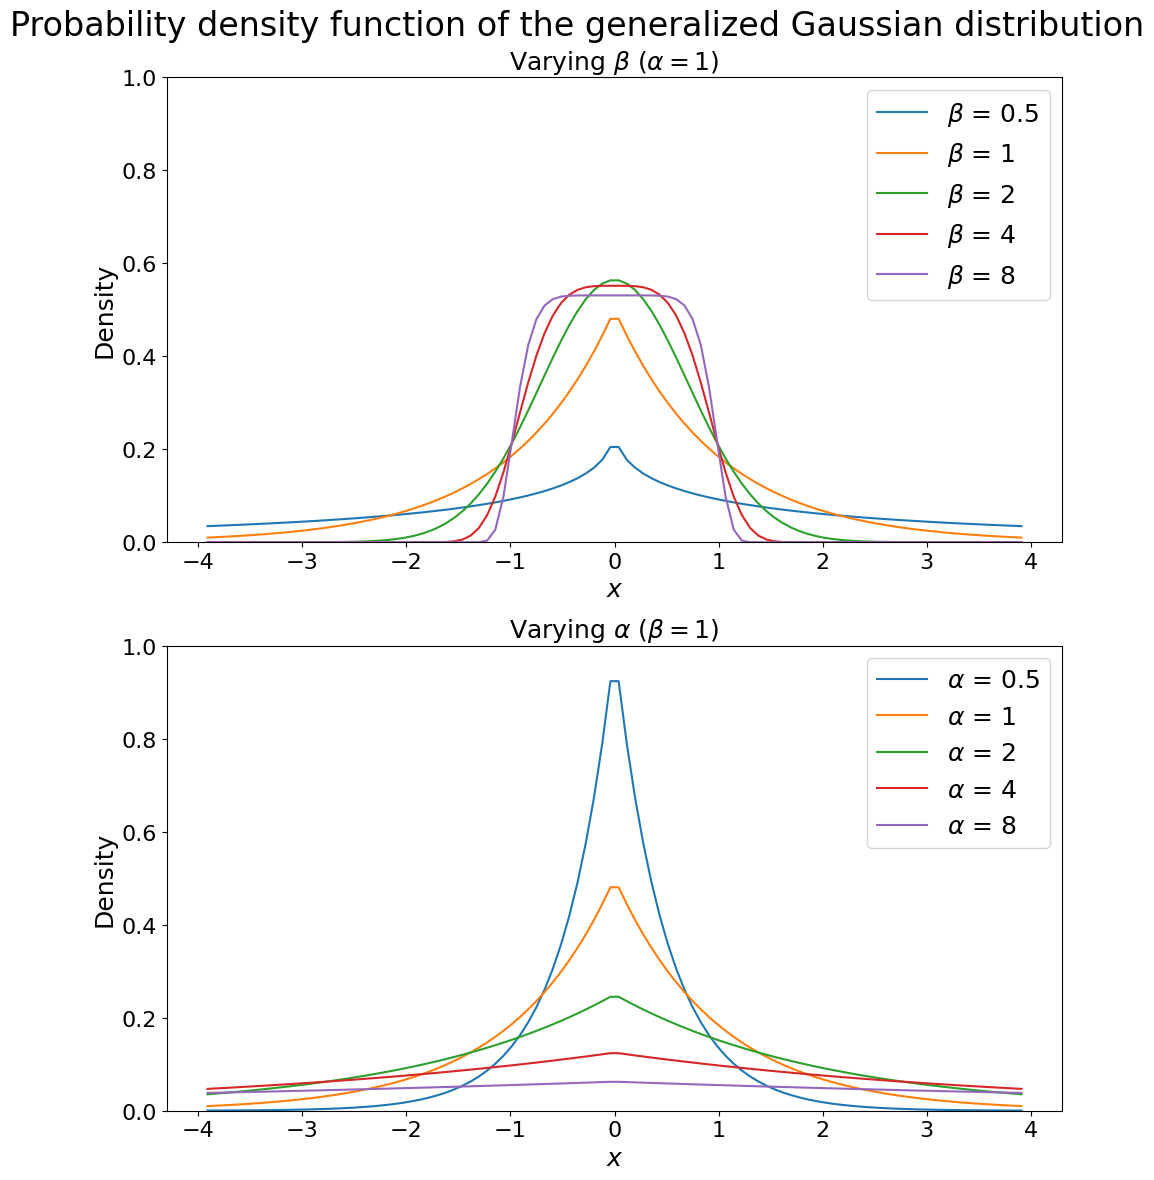

In [4]:
# Based on: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gennorm.html
from scipy.stats import gennorm
import matplotlib.pyplot as plt
import numpy as np

fs = 18 # fontsize

beta = 1
fig, ax = plt.subplots(2, 1, figsize = (10,12))

x = np.linspace(gennorm.ppf(0.01, beta),gennorm.ppf(0.99, beta), 100)

alpha = 1
for beta in [0.5, 1, 2, 4, 8]:
    ax[0].plot(x, gennorm.pdf(x, beta, loc=0, scale=alpha), label=f'$\\beta$ = {beta}')
ax[0].set_title('Varying $\\beta$ ($\\alpha = 1$)', fontsize = fs)

beta = 1
for alpha in [0.5, 1, 2, 4, 8]:
    ax[1].plot(x, gennorm.pdf(x, beta, loc=0, scale=alpha), label=f'$\\alpha$ = {alpha}')
ax[1].set_title('Varying $\\alpha$ ($\\beta = 1$)', fontsize = fs)

for a in ax:
    a.legend(fontsize = fs)
    a.set_ylabel('Density', fontsize = fs)
    a.set_xlabel('$x$', fontsize = fs)
    a.tick_params(axis='both', labelsize=fs-2)
    a.set_ylim(0, 1)
#     a.set_xticks()
    
fig.suptitle('Probability density function of the generalized Gaussian distribution', fontsize=24)
plt.tight_layout()
plt.savefig('./images/GGD.pdf',transparent = True, bbox_inches='tight')
plt.show()

In [2]:
for dataset in datasets:
    lst_args = ['--imagenet-val', dataset] 
    args = parse_args(lst_args)
    data = get_data(args, (preprocess_train, preprocess_val), iter=0, tokenizer=get_tokenizer(args.model), model = model)
    print(dataset)
    for i, item in tqdm(data['zeroshot-val'].dataloader):
        item = item

WHU-RS19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


RSSCN7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:18<00:00,  2.40it/s]


AID


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:03<00:00,  1.27it/s]


RESISC45


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 493/493 [02:10<00:00,  3.78it/s]


In [12]:
target_path = './data/AID/'

for folder in os.listdir(target_path):
    print(folder)
    folder_path = os.path.join(target_path, folder)
    if (not os.path.isdir(folder_path)) or folder == 'numpy_files':
        continue
        
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        print('Img size:', os.path.getsize(item_path))
        img = Image.open(item_path).convert('RGB')
        np_img = np.array(img)
        np_path = os.path.join('./data/AID/numpy_files', item).replace('.jpg', '.npy')
        np.save(np_path, np_img)
        print('Np size:', os.path.getsize(np_path))
        break
    break

Airport
Img size: 437084
Np size: 1080128


In [15]:
%timeit Image.fromarray(np.load(np_path))
%timeit Image.open(item_path).convert('RGB')

833 µs ± 46.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
6.24 ms ± 150 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
# print(os.listdir('./data/AID/Center')) 
img1 = './data/AID/Center/center_1.jpg'
img2 = './data/RSICD/RSICD_images/river_190.jpg'
img3 = './data/NWPU-RESISC45/ship/ship_001.jpg'
os.path.getsize(img1), os.path.getsize(img2), os.path.getsize(img3)

(361815, 44248, 15555)

In [29]:
image = Image.open(img1).convert('RGB')
image = image.resize((int(image.width*0.5), int(image.height*0.5)))
# image.draft('RGB', (int(image.width*0.5), int(image.height*0.5)))
# image2 = Image.open(img2).convert('RGB')

In [30]:
image.size

(300, 300)

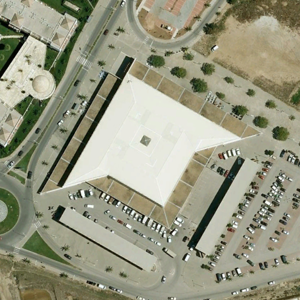

In [31]:
image

In [17]:
image2.size

(224, 224)

In [14]:
%%time
for _ in range(100):
    preprocess_train(image)

CPU times: user 1min 55s, sys: 210 ms, total: 1min 55s
Wall time: 9.27 s


In [13]:
%%time
for _ in range(100):
    preprocess_train(image2)

CPU times: user 3min 11s, sys: 498 ms, total: 3min 11s
Wall time: 14.8 s


In [26]:
preprocess_train

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic, antialias=warn)
    <function _convert_to_rgb at 0x14f1fec5a200>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

[0.   0.05 0.1  0.2  0.4  0.2 ] [0.1, 0.1, 0.1, 1, 1, 1]
[0.0, 0.005000000000000001, 0.015000000000000003, 0.21500000000000002, 0.615, 0.815]


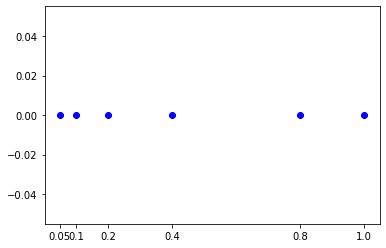

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_custom_xticks(xticks):
    # Round the xticks to the nearest multiple of 10
    base = 10
    xticks_rounded = [base**round(math.log(x, base)) for x in xticks]

    # Compute the difference between consecutive label ratios (to get a sense of scale)
    spacing = np.diff(xticks) 
    spacing = np.append([0], spacing) # The first element gets no spacing
    print(spacing, xticks_rounded)
    spacing = [spacing[i] * xticks_rounded[i] for i in range(len(spacing))]
    

    cumulative_spacing = [sum(spacing[:i+1]) for i in range(len(spacing))]
    
    print(cumulative_spacing)
    plt.xticks(xticks, xticks)
    plt.plot(xticks, [0] * len(xticks), 'bo')  # Placeholder points for demonstration

    plt.show()

# Example usage with xticks smaller than 1
xticks = [0.05, 0.1, 0.2, 0.4, 0.8, 1.0]
plot_custom_xticks(xticks)